In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import requests

In [2]:
# params generated from this website: https://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__HE__HE0110__HE0110A/SamForvInk2/table/tableViewLayout1/
params = """
    {
      "query": [
        {
          "code": "Region",
          "selection": {
            "filter": "vs:RegionRiket99",
            "values": []
          }
        },
        {
          "code": "Kon",
          "selection": {
            "filter": "item",
            "values": [
              "1+2"
            ]
          }
        },
        {
          "code": "Alder",
          "selection": {
            "filter": "item",
            "values": [
              "tot16+"
            ]
          }
        },
        {
          "code": "Inkomstklass",
          "selection": {
            "filter": "item",
            "values": [
              "0",
              "1-19",
              "20-39",
              "40-59",
              "60-79",
              "80-99",
              "100-119",
              "120-139",
              "140-159",
              "160-179",
              "180-199",
              "200-219",
              "220-239",
              "240-259",
              "260-279",
              "280-299",
              "300-319",
              "320-339",
              "340-359",
              "360-379",
              "380-399",
              "400-499",
              "500-599",
              "600-799",
              "800-999",
              "1000+"
            ]
          }
        },
        {
          "code": "ContentsCode",
          "selection": {
            "filter": "item",
            "values": [
              "HE0110K4",
              "HE0110K3"
            ]
          }
        },
        {
          "code": "Tid",
          "selection": {
            "filter": "item",
            "values": [
              "2018"
            ]
          }
        }
      ],
      "response": {
        "format": "json"
      }
    }
"""

In [3]:
r = requests.post(url='http://api.scb.se/OV0104/v1/doris/sv/ssd/START/HE/HE0110/HE0110A/SamForvInk2',
             data=params)
df = pd.DataFrame(r.json()['data']).explode('values')
df.head()

,key,values
0,"[1+2, tot16+, 0, 2018]",0.0
0,"[1+2, tot16+, 0, 2018]",497842
1,"[1+2, tot16+, 1-19, 2018]",2472.4
1,"[1+2, tot16+, 1-19, 2018]",291786
2,"[1+2, tot16+, 20-39, 2018]",4870.8


In [4]:
df['col_names'] = ['sum', 'n_people']*int(df.shape[0]/2)
df['key'] = df.key.apply(lambda x: x[2])
df.head()

,key,values,col_names
0,0,0.0,sum
0,0,497842,n_people
1,1-19,2472.4,sum
1,1-19,291786,n_people
2,20-39,4870.8,sum


In [5]:
df['range'] = df.key.apply(lambda x: x.split('-'))
df[['min_', 'max_']] = pd.DataFrame(df.range.tolist(), index=df.index)

df['max_'] = np.where((df.max_.isnull()) & (df.min_=='0'), '0',
                      np.where((df.max_.isnull()) & (df.min_=='1000+'), '332000',
                               df.max_))

df['min_'] = np.where(df.min_=='1000+', '1000', df.min_)

df = df[[
    'key', 'min_', 'max_'
]].drop_duplicates(
).merge(
    df.pivot(index='key', columns='col_names', values='values'),
    left_on='key',
    right_index=True
)

df = df.astype({'min_': 'int', 'max_': 'int', 'n_people': 'int', 'sum': 'float'})

In [6]:
df

,key,min_,max_,n_people,sum
0,0,0,0,497842,0.0
1,1-19,1,19,291786,2472.4
2,20-39,20,39,164081,4870.8
3,40-59,40,59,153923,7702.5
4,60-79,60,79,127220,8875.1
5,80-99,80,99,181623,16580.2
6,100-119,100,119,282285,31267.4
7,120-139,120,139,263903,34370.1
8,140-159,140,159,299528,44976.2
9,160-179,160,179,326987,55617.1


## Creating the individual-level approximation

In [7]:
inc_data = []
for i in range(df.shape[0]):
    if i == df.shape[0]-1:
        inc_data.append((np.random.exponential(scale=30, size=df.loc[i, 'n_people'])+1)*1000)
    else:
        inc_data.append(np.random.uniform(low=df.loc[i, 'min_'], high=df.loc[i, 'max_'], size=df.loc[i, 'n_people']))
    
inc_data = [obs for array in inc_data for obs in array]

In [8]:
len(inc_data)

8296079

In [9]:
max(inc_data)

350977.5630688766

# Plot

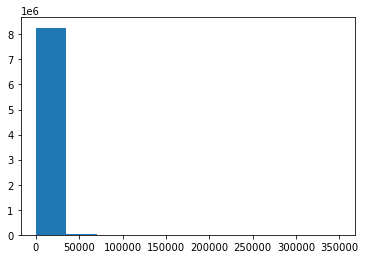

In [10]:
plt.hist(inc_data);

## Split the plot...

In [11]:
df2 = pd.DataFrame({
    'incomes':inc_data,
    '1m+': np.where(np.array(inc_data)>=1000, 1, 0)
})

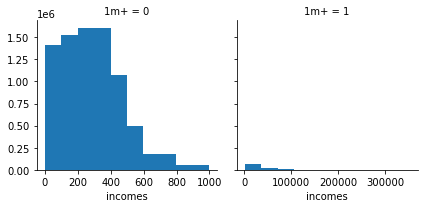

In [12]:
p = sns.FacetGrid(df2, col='1m+', sharex=False, sharey=True)
p.map_dataframe(plt.hist, 'incomes');

# What happens to the sampling distribution when there are extreme outliers?

In [13]:
df_working = df2[df2.incomes>0]

In [14]:
sampling_dist_100 = []
sampling_dist_1000 = []
sampling_dist_10000 = []

for i in range(1000):
    sampling_dist_100.append(np.random.choice(df_working.incomes, 100, replace=False).mean())
    sampling_dist_1000.append(np.random.choice(df_working.incomes, 1000, replace=False).mean())
    sampling_dist_10000.append(np.random.choice(df_working.incomes, 10000, replace=False).mean())

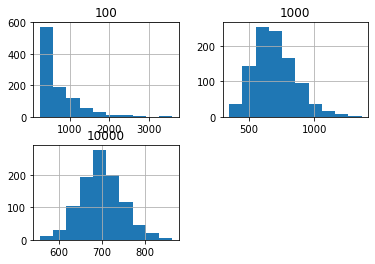

In [15]:
samp_dist_df = pd.DataFrame({
    '100': sampling_dist_100,
    '1000': sampling_dist_1000,
    '10000': sampling_dist_10000
})

samp_dist_df.hist();

# Why you shouldn't use distributions with extreme outliers in AB tests

In [ ]:
mean_value = df_working.incomes.mean()

plt.hist(df_working[df_working.incomes < 1000]['incomes'])
plt.vlines(x=mean_value, ymin=0, ymax=1.6e6, color='k')
plt.annotate('mean of distribution', (700, 1e6));

In [ ]:
sorted_incomes = np.sort(df_working.incomes)
number_less_than_mean = sum(sorted_incomes < mean_value)

print(f'the mean of the distribution corresponds to roughly the {round(number_less_than_mean / sorted_incomes.shape[0], 4)*100} percentile.')